In [1]:
import settings
import os
from emoji import Emoji, EmojiOutputFormat
import numpy as np
from main import batch_load, map_y
from sklearn import metrics
import random

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense

2022-12-05 04:36:57,612 [INFO]: Logging is now in charge of logging.


[INFO] Settings: Start initializing.
[INFO] Settings: Folder already exists in Dir /home/loe/Projects/STATS-304/GP/.config/, skipping creation.
[INFO] Settings: Reading from file.
[INFO] Settings: Performing integrity check.
[INFO] Settings: New config file generated.
[INFO] Settings: Apply environment variable.
[INFO] Settings: Folder already exists in Dir /home/loe/Projects/STATS-304/GP/.config/, skipping creation.
[INFO] Settings: Folder already exists in Dir /home/loe/Projects/STATS-304/GP/.data, skipping creation.
[INFO] Settings: ROOT_DIR - /home/loe/Projects/STATS-304/GP
[INFO] Settings: CONFIG_DIR - /home/loe/Projects/STATS-304/GP/.config/
[INFO] Settings: DATA_DIR - /home/loe/Projects/STATS-304/GP/.data
[INFO] Settings: LOG_LEVEL - DEBUG
[INFO] Settings: Finish initializing.


2022-12-05 04:36:58.272804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 04:36:59.280437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-05 04:36:59.280582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-05 04:36:59.280594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
# Read the data
DATA_DIR = os.environ["DATA_DIR"]
X, y = batch_load(DATA_DIR, {"Facebook": "Meta", "Microsoft": "Microsoft", "Apple": "Apple"}, output_size=(36,36), output_format=EmojiOutputFormat.grayscale)
# Transform y
y = map_y(y)

# Preprocessing the input data
# Normalize input vector
X = X/ 255.0
y = y/ 2

/home/loe/.local/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
# random.shuffle(iris) # This thing breaks list. I do not know why.
X_new = X.copy()
y_new = y.copy()
sequence = []
random.seed(114)
while len(sequence) != X.shape[0]:
    i = random.randint(0,X.shape[0]-1)
    if i not in sequence:
        sequence.append(i)
#print(sequence)
for i_ind, i_val in enumerate(X):
    X_new[sequence[i_ind]] = i_val
    y_new[sequence[i_ind]] = y[i_ind]
X = X_new.copy()
y = y_new.copy()

In [6]:
# Visualize input data
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (6226, 1296)
y shape: (6226,)


In [7]:
portion = 0.3
num_of_train = int(X.shape[0]*(1-portion))
X_train = X[:num_of_train]
y_train = y[:num_of_train]
X_test = X[num_of_train:]
y_test = y[num_of_train:]

In [14]:
## NN
# Layout the model
input_dim = X.shape[1]
hidden_layers = 40
hidden_nodes = 400

with tf.device('/CPU:0'):
    model = tf.keras.models.Sequential()

    model.add(Dense(hidden_nodes, activation = "relu", input_dim=input_dim))
    for i in range(int(hidden_layers)):
        model.add(Dense(hidden_nodes, activation = "relu"))

    model.add(Dense(1,activation = "sigmoid"))

    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss="mse", metrics="mse")
    print("Finish compiling")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 400)               518800    
                                                                 
 dense_33 (Dense)            (None, 400)               160400    
                                                                 
 dense_34 (Dense)            (None, 400)               160400    
                                                                 
 dense_35 (Dense)            (None, 400)               160400    
                                                                 
 dense_36 (Dense)            (None, 400)               160400    
                                                                 
 dense_37 (Dense)            (None, 400)               160400    
                                                                 
 dense_38 (Dense)            (None, 400)              

In [15]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
        baseline=None, restore_best_weights = True
    )
with tf.device('/CPU:0'):
    history = model.fit(X_train, y_train, batch_size = 32, epochs=1000, validation_split=0.2,verbose=True, callbacks=callback)

Epoch 1/1000
109/109 [==============================] - 8s 49ms/step - loss: 0.1681 - mse: 0.1681 - val_loss: 0.1656 - val_mse: 0.1656
Epoch 2/1000
109/109 [==============================] - 5s 43ms/step - loss: 0.1675 - mse: 0.1675 - val_loss: 0.1647 - val_mse: 0.1647
Epoch 3/1000
109/109 [==============================] - 5s 43ms/step - loss: 0.1664 - mse: 0.1664 - val_loss: 0.1634 - val_mse: 0.1634
Epoch 4/1000
109/109 [==============================] - 5s 43ms/step - loss: 0.1653 - mse: 0.1653 - val_loss: 0.1590 - val_mse: 0.1590
Epoch 5/1000
109/109 [==============================] - 5s 44ms/step - loss: 0.1224 - mse: 0.1224 - val_loss: 0.1066 - val_mse: 0.1066
Epoch 6/1000
109/109 [==============================] - 5s 45ms/step - loss: 0.0973 - mse: 0.0973 - val_loss: 0.0953 - val_mse: 0.0953
Epoch 7/1000
109/109 [==============================] - 5s 43ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.0812 - val_mse: 0.0812
Epoch 8/1000
109/109 [==============================] -

In [16]:
# Evaluate the result

In [17]:
print(history.history)

{'loss': [0.16810736060142517, 0.1675446480512619, 0.16641506552696228, 0.16529783606529236, 0.12236495316028595, 0.09725110977888107, 0.07785904407501221, 0.0686713233590126, 0.061603792011737823, 0.056046560406684875, 0.048854682594537735, 0.04240958392620087, 0.03815610706806183, 0.033470332622528076, 0.029682276770472527, 0.024085668846964836, 0.018197646364569664, 0.01380440779030323, 0.0170303825289011, 0.01363498717546463, 0.01318838819861412, 0.010045117698609829, 0.008870790712535381, 0.007622985169291496, 0.010846767574548721, 0.006553493905812502, 0.006309377960860729], 'mse': [0.16810736060142517, 0.1675446480512619, 0.16641506552696228, 0.16529783606529236, 0.12236495316028595, 0.09725110977888107, 0.07785904407501221, 0.0686713233590126, 0.061603792011737823, 0.056046560406684875, 0.048854682594537735, 0.04240958392620087, 0.03815610706806183, 0.033470332622528076, 0.029682276770472527, 0.024085668846964836, 0.018197646364569664, 0.01380440779030323, 0.0170303825289011, 0

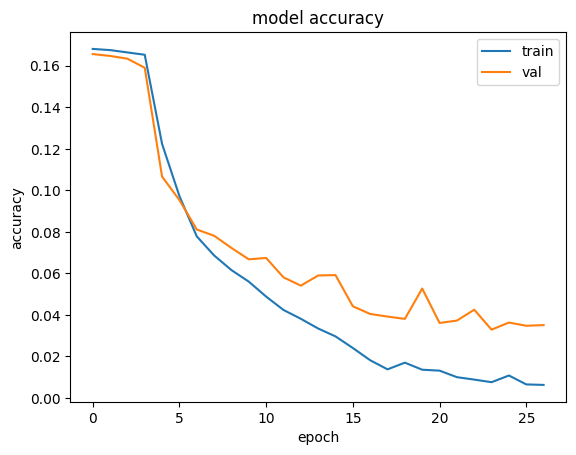

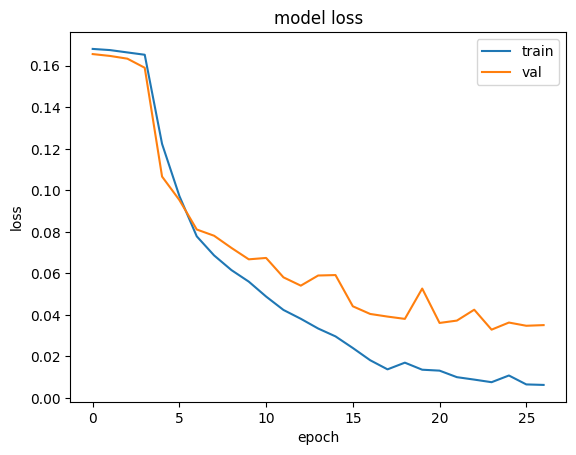

In [18]:
# Visualize the result
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [19]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
print(y_pred.flatten())
y_pred_ = y_pred.copy()
for ind, val in enumerate(y_pred):
    if val < 1/3:
        res = 0
    elif val >2/3:
        res = 2
    else:
        res = 1        
    y_pred_[ind] = res
y_pred = y_pred_.astype('int8')
print(y_pred)

59/59 [==============================] - 1s 10ms/step
[0.97850937 0.96902996 0.9783181  ... 0.19602309 0.0388255  0.01982673]
[2 2 2 ... 0 0 0]


In [20]:
# print(metrics.rand_score(y_test, y_pred))
formatted_y_test = (y_test*2).astype('int8')
print("Confusion Matrix:\n", metrics.confusion_matrix(formatted_y_test, y_pred))
print(f"Accuracy: {np.sum(np.equal(formatted_y_test, y_pred))/y_pred.shape[0]}")

Confusion Matrix:
 [[688  50  21]
 [ 36 511  46]
 [ 17  53 446]]
Accuracy: 0.8806209850107066
